In [150]:
import numpy as np
import zarr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import pandas as pd
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.3.5


In [199]:
zarr_path = '/Users/dennistpw/Projects/microctonus/microctonus_genom/snpdata/microctonus_fullcohort_filtered.zarr/'
callset = zarr.open_group(zarr_path, mode='r')
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['CHROM','POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'QUAL', 'MQRankSum', 'ReadPosRankSum', 'FS', 'SOR' ,'AF'])

In [214]:
pos_all = allel.SortedIndex(variants.compress(mask)['POS'])

In [215]:
chrom = 'scaffold_2'

In [216]:
mask = callset['variants/CHROM'][:]==chrom

In [217]:
x = allel.GenotypeArray(callset['calldata/GT'])

In [218]:
scaf1_gts = x.compress(mask, axis=0)

In [219]:
df_samples = pd.read_csv('/Users/dennistpw/Projects/microctonus/microctonus_genom/sampledata/myhponly_metadata.csv', index_col = 'order')

In [220]:
pop1 = 'Bariloche'
pop2 = 'Concepcion'
n_samples_pop1 = np.count_nonzero(df_samples.Site == pop1)
n_samples_pop2 = np.count_nonzero(df_samples.Site == pop2)
print(pop1, n_samples_pop1, pop2, n_samples_pop2)

Bariloche 11 Concepcion 9


In [221]:
# dictionary mapping population names to sample indices
subpops = {
    pop1: df_samples[df_samples.Site == pop1].index,
    pop2: df_samples[df_samples.Site == pop2].index,
}
# allele counts
acs = scaf1_gts.count_alleles_subpops(subpops)
acs

{'Bariloche': <AlleleCountsArray shape=(148197, 2) dtype=int32>
 19  3
 11 11
 11 11
 ...
 22  0
 22  0
 11 11,
 'Concepcion': <AlleleCountsArray shape=(148197, 2) dtype=int32>
 13  5
 10  8
  9  9
 ...
 18  0
 18  0
  9  9}

In [222]:
acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:])
flt = acu.is_segregating() & (acu.max_allele() == 1)
print('retaining', np.count_nonzero(flt), 'SNPs')

retaining 33378 SNPs


In [223]:
pos = pos_all.compress(flt)
ac1 = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2])
ac2 = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2])
genotype = scaf1_gts.compress(flt, axis=0)
genotype

<GenotypeArray shape=(33378, 182, 2) dtype=int8>
0/1 0/0 0/1 0/0 0/1 ... 0/0 0/0 0/0 0/0 0/0
0/1 0/1 0/1 0/1 0/1 ... 0/1 0/1 0/1 0/1 0/0
0/1 0/1 0/1 0/1 0/1 ... 0/1 0/1 0/1 0/1 0/1
...
0/1 0/1 0/1 0/1 0/1 ... 0/1 0/1 0/1 1/1 0/0
0/1 0/1 0/1 0/1 0/1 ... 0/1 0/1 0/1 0/1 0/1
0/1 0/1 0/1 0/1 0/1 ... 0/0 0/1 0/1 0/1 0/1

In [224]:
pop1_idx = subpops[pop1]
# sample indices for population 2
pop2_idx = subpops[pop2]
a, b, c = allel.weir_cockerham_fst(genotype, subpops=[pop1_idx, pop2_idx], max_allele=1)
snp_fst_wc = (a / (a + b + c))[:, 0]
snp_fst_wc

array([ 0.0231561 ,  0.00118401,  0.        , ..., -0.03487118,
       -0.01033827,  0.        ])

In [225]:
num, den = allel.hudson_fst(ac1, ac2)
snp_fst_hudson = num / den
snp_fst_hudson

array([ 0.00765082, -0.04668534, -0.05322129, ..., -0.05059343,
       -0.02829486, -0.05322129])

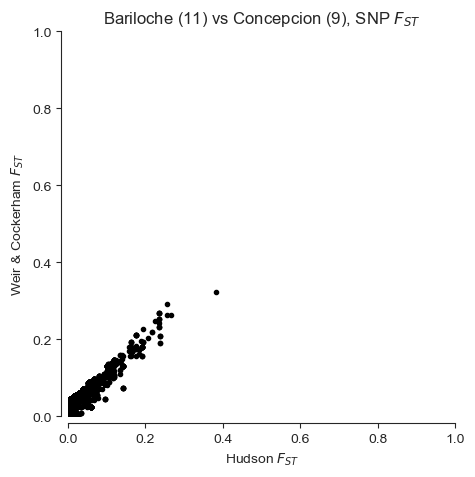

In [226]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.despine(ax=ax, offset=5)
ax.plot(snp_fst_hudson, snp_fst_wc, color='k', marker='.', linestyle=' ')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Hudson $F_{ST}$')
ax.set_ylabel('Weir & Cockerham $F_{ST}$')
ax.set_title('%s (%s) vs %s (%s), SNP $F_{ST}$' % (pop1, n_samples_pop1, pop2, n_samples_pop2));

In [243]:
def plot_fst(ac1, ac2, pos, blen=1):
    
    fst, se, vb, _ = allel.blockwise_hudson_fst(ac1, ac2, blen=blen)
    
    # use the per-block average Fst as the Y coordinate
    y = vb
    
    # use the block centres as the X coordinate
    x = allel.moving_statistic(pos, statistic=lambda v: (v[0] + v[-1]) / 2, size=blen)
    
    # plot
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.despine(ax=ax, offset=5)
    ax.plot(x, y, 'k-', lw=.5)
    ax.set_ylabel('$F_{ST}$')
    ax.set_xlabel('Chromosome %s position (bp)' % chrom)
    ax.set_xlim(0, pos.max())
    

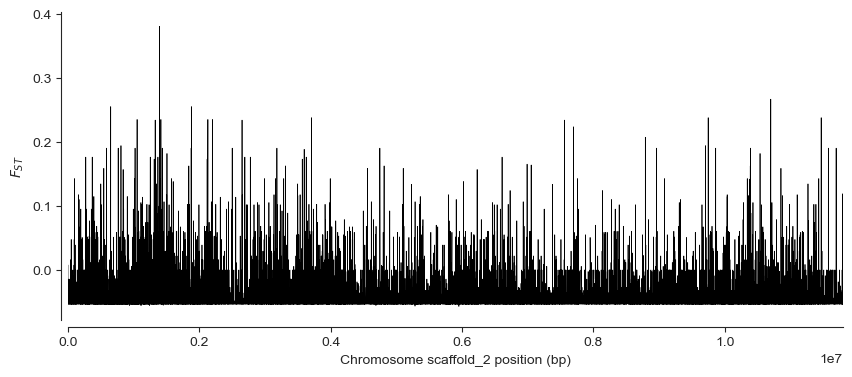

In [244]:
plot_fst(ac1, ac2, pos)